<a href="https://colab.research.google.com/github/mohamedyosef101/101_learning_area/blob/area/PyTorch/02_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks (CNNs)

In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision.models

import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
import random
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cpu


In [3]:
# SEED
def set_seed(seed = 7):
  '''Sets the seed of the entire notebook so
  results are the same every time we run.'''
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# Small example; what is convolution?

Image shape: (320, 320, 3)


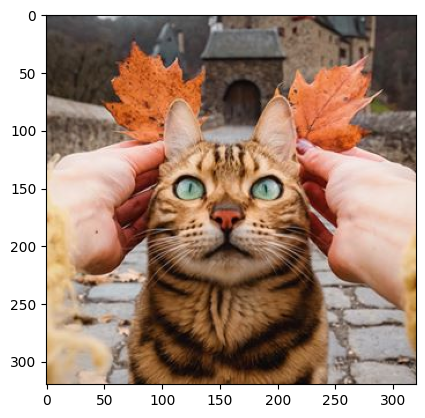

In [14]:
image = plt.imread('/content/suki.jpg')

print('Image shape:', image.shape)
plt.imshow(image)

In [15]:
# Before applying any convolutions...

# 1. convert to tensor
transform = transforms.ToTensor()
image = transform(image)
print('Image Tensor:', image.shape, '\n')

# 2. Bring the channel in front >> NO NEED <<
# image = image.permute(2, 0, 1)
# print('Permuted Channel:', image.shape, '\n')

# 3. Add one more dimension for batching (1 because we have one image)
image = image.reshape([1, 3, 320, 320]).float()
print('Final image shape:', image.shape, '\n')

Image Tensor: torch.Size([3, 320, 320]) 

Final image shape: torch.Size([1, 3, 320, 320]) 



In [21]:
# create 1 convolutional layer

conv1 = nn.Conv2d(in_channels=3, out_channels=5,
                  kernel_size=5, padding=0, stride=1)

# apply conv1 to image
conv1_img = conv1(image)
print('Convoluted Image shape:', conv1_img.shape)

Convoluted Image shape: torch.Size([1, 5, 316, 316])


In [23]:
# Convolution parameters
conv_params = list(conv1.parameters())
print('len(conv_params):', len(conv_params))
print('Filters:', conv_params[0].detach().numpy().shape)
print('Biases:', conv_params[1].detach().numpy().shape) # one for each channel

len(conv_params): 2
Filters: (5, 3, 5, 5)
Biases: (5,)


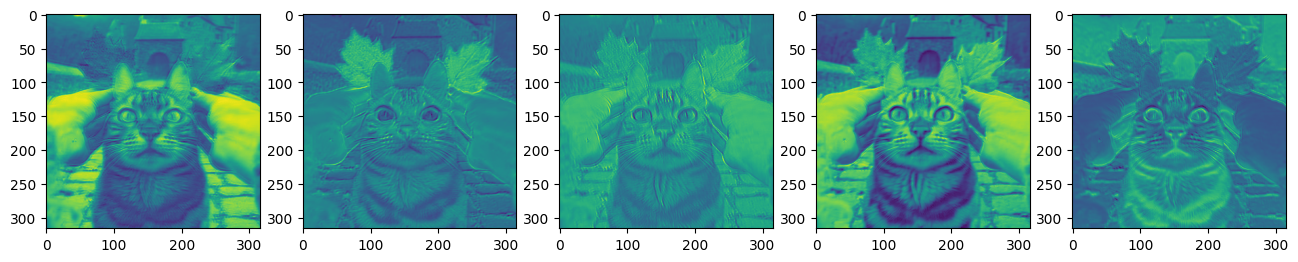

In [24]:
### Visualize Convolutions ###

conv1_numpy = conv1_img.detach().numpy()
conv1_numpy = conv1_numpy.reshape([5, 316, 316]) # remove the dim 1 batch

# Normalize to [0, 1] for plotting
max = np.max(conv1_numpy)
min = np.min(conv1_numpy)

conv1_numpy = conv1_numpy -min / (max - min) # Normalization

# plotting the channels
plt.figure(figsize=(16, 5))

for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(conv1_numpy[i])

# AlexNet

For more information [click here](https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951)

In [25]:
# import alexNet
alexNet = torchvision.models.alexnet(pretrained=True)
alexNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 92.7MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# MNIST Classification using CNNs

## Build and try the model

In [41]:
class CNN_MNISTClassifier(nn.Module):
  def __init__(self):
    super(CNN_MNISTClassifier, self).__init__()
    self.features = nn.Sequential(nn.Conv2d(1, 16, 3),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2, 2),
                                  nn.Conv2d(16, 10, 3),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2))
    self.classifier = nn.Sequential(nn.Linear(10*5*5, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 84),
                                    nn.ReLU(),
                                    nn.Linear(84, 10))

  def forward(self, image, prints=False):
    if prints: print('Original Image shape:', image.detach().numpy().shape)

    image = self.features(image)
    if prints: print('Convol Image shape:', image.detach().numpy().shape)

    image = image.view(-1, 10*5*5)
    if prints: print('Vectorized Image shape:', image.detach().numpy().shape)

    out = self.classifier(image)
    if prints: print('out:', out)

    # Apply softmax
    out = F.log_softmax(out, dim=1)
    if prints: print('Log softmax (out):', out)
    return out

In [42]:
# Understand how it works
model_example = CNN_MNISTClassifier()
model_example

CNN_MNISTClassifier(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=250, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [43]:
%%capture

# importing the MNIST data
mnist_example = MNIST('data', train=True, download=True,
                      transform=transforms.ToTensor())

image_ex, label_ex = list(mnist_example)[7]
image_ex = image_ex.reshape([1, 1, 28, 28])

In [44]:
# see how it works
out = model_example(image_ex, prints=True)

Original Image shape: (1, 1, 28, 28)
Convol Image shape: (1, 10, 5, 5)
Vectorized Image shape: (1, 250)
out: tensor([[ 0.0328, -0.0493,  0.0929,  0.0612, -0.0166,  0.0770,  0.0783,  0.0098,
         -0.0488, -0.0941]], grad_fn=<AddmmBackward0>)
Log softmax (out): tensor([[-2.2859, -2.3680, -2.2259, -2.2576, -2.3354, -2.2417, -2.2405, -2.3090,
         -2.3676, -2.4128]], grad_fn=<LogSoftmaxBackward0>)


## Create criterion and optimizer

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_example.parameters(),
                       lr=0.001, weight_decay=0.0005)

loss = criterion(out, torch.tensor(label_ex).reshape(1))
print('Loss:', loss)

optimizer.zero_grad()
loss.backward()
optimizer.step()

Loss: tensor(2.2576, grad_fn=<NllLossBackward0>)
